# Introduction

Housing price is an important indicator of the quality of a neighborhood. Generally, good neighborhoods tend to have higher home sale prices because the area is desirable and there is a high demand for a limited amount of housing. Economically, this shifts the balance of supply and demand onto the side of demand, which can dramatically drive up price. 

Housing price can be correlated with safety, quality of school districts, closeness to shops and activites, and generally the desirability of living in an area. 

I chose to work with the following dataset from the Western Pennsylvania Regional Data Center (WPRDC): https://data.wprdc.org/dataset/market-value-analysis-2021

The dataset analyzes several factors, including median home sale price per Allegheny county geoid, from 2017-2019. As an aside, tracts are divisions of neighborhoods that consist of a few blocks that are utilized by the census to accurately profile small subregions and obtain data granularity. 

Geopandas dataframe for all of Allegheny county has 1114 entries
Geopandas dataframe for Pittsburgh only has 449 entries
Geopandas dataframe merged with neighborhood codes has 513 entries 

Census Tracts Highest Median Sale Price Mapped to Neighborhood 

                  Neighborhood  Median Home Sale Price  \
106                  Shadyside                779300.0   
122  Central Business District                710000.0   
123  Central Business District                710000.0   
164                  Shadyside                645000.0   
165                  Shadyside                645000.0   
50         Squirrel Hill North                625000.0   
42         Squirrel Hill North                621798.0   
43         Squirrel Hill North                621798.0   
46         Squirrel Hill North                612500.0   
424                  Troy Hill                606500.0   
425                  Troy Hill                606500.0   
487                  Troy Hill                606

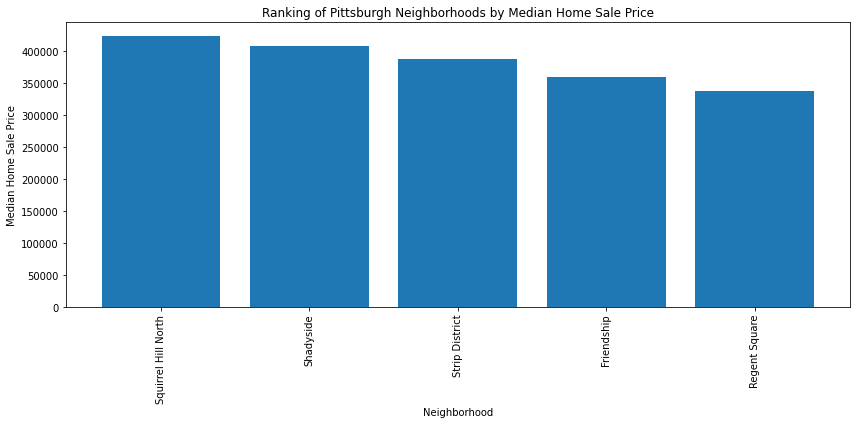



Top 10 Average Home Sale Prices 

                 Neighborhood  Average Home Sale Price
75        Squirrel Hill North                 424257.0
67                  Shadyside                 409013.0
79             Strip District                 388000.0
33                 Friendship                 360000.0
65              Regent Square                 338350.0
83                  Troy Hill                 334000.0
76        Squirrel Hill South                 329780.0
39              Highland Park                 322875.0
63               Point Breeze                 309130.0
16  Central Business District                 295750.0




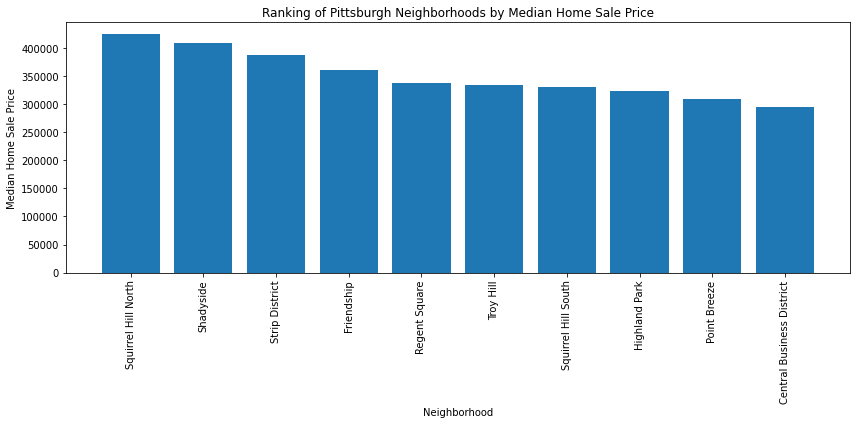

Bottom 10 Average Home Sale Price 

         Neighborhood  Average Home Sale Price
42      Homewood West                   1026.0
41     Homewood South                   6985.0
40     Homewood North                  20750.0
27         East Hills                  21500.0
43          Knoxville                  21792.0
2           Allentown                  24250.0
35         Glen Hazel                  26629.0
6   Bedford Dwellings                  26750.0
10              Bluff                  26876.0
3           Arlington                  27560.0


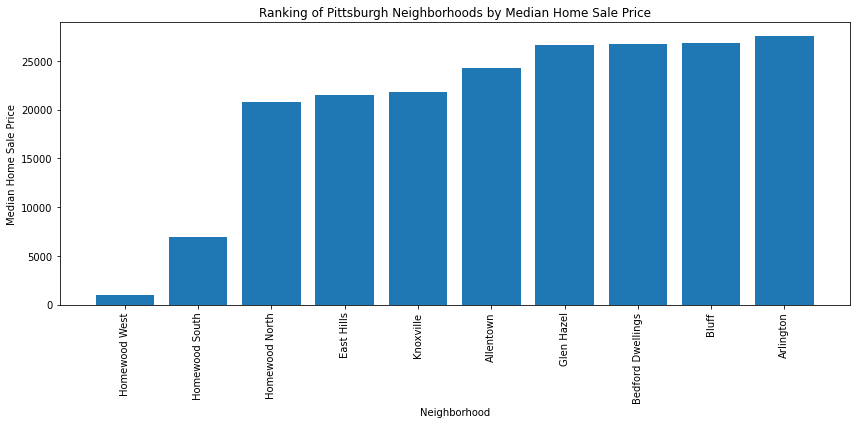

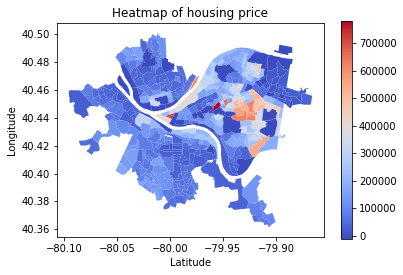

In [6]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapefile
from shapely.geometry import Point


#housing dataset that is imported as .shp file into geopandas
shp_file_path = "./PITT_MVA/Pitts_Allegheny_MVA2021.shp"
gdf = gpd.read_file(shp_file_path)

#test to see what is dropped from the gdf once 
#print(gdf["MSP1719"].nlargest(10))

print("Geopandas dataframe for all of Allegheny county has " + str(len(gdf)) + " entries")

#pittsburgh boundary that is imported as .shp file into geopandas
shp_file_path_2 = "./PGH_BOUND/City_Boundary.shp"
gdf_2 = gpd.read_file(shp_file_path_2)

#converted the mapping of latitude and longitude to the same formats
#intersection of data and boundary geopandas sets
gdf_2 = gdf_2.to_crs(gdf.crs)
intersection = gpd.overlay(gdf, gdf_2, how='intersection')

#will produce a dataframe containing just Pittsburgh data
df = intersection.drop(columns='geometry')
print("Geopandas dataframe for Pittsburgh only has " +  str(len(df)) + " entries")


#got a file that converted the geoid data into Neighborhood data and merged with existing intersection df
df_geoid_cvt = pd.read_excel("Geoid to Neighborhood Map.xlsx")

#Cut geoid codes to 11 digits, as 12 digit codes include block number. Here, that granularity is not relevant
df['geoid_nb'] = df['geoid'].astype(str).str[:11]
df_geoid_cvt['geoid_nb'] = df_geoid_cvt['GEOID10'].astype(str).str[:11]

# Merge the DataFrames based on the new column containing the first 11 digits of the GeoID numbers
merged_df = pd.merge(df, df_geoid_cvt, on='geoid_nb', how="left")
print("Geopandas dataframe merged with neighborhood codes has " + str(len(merged_df)) + " entries \n")

#Cleaned the data of all unnecessary columns
merged_df = merged_df.drop(['geoid', 'VSP1719', 'FID', 'AREA_x', 'PERIMETER', 'BOUNDARY_', 'BOUNDARY_I', 'Shape_Leng',
                         'SHAPE_Le_1', 'SHAPE_Area', 'FID_BlockG', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10',
                            'GEOID10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'FID_Neighb', 
                            'AREA_y', 'HOOD_NO', 'DPWDIV', 'UNIQUE_ID', 'SECTORS', 'Page_Numbe', 'ESRI_OID', 'NEIGHBOR_'], axis=1)


merged_df = merged_df.rename(columns={'MSP1719': 'Median Home Sale Price', 'PHHOO': ' Percent Owner Occupied', 
                                      'PROSubHH': 'Percent Subsidy Recipients', 'pforc1719': 'Percent Foreclosures', 'pVacLot': 'Percent Vacant Lots',
                                      'pViolAddress': 'Percent Housing Violations', 'pcond_flag' : 'Percent Parcels in Poor Condition', 'MVA21' : 'Letter Grade Assessment', 'HOOD' : "Neighborhood"})
    

#print(merged_df.head(10))

#top_30_values = merged_df.nlargest(30, 'Median Home Sale Price')
#print(top_30_values)

#naive solution printing only the census tracts with the largest housing sale price
largest_idx = merged_df['Median Home Sale Price'].nlargest(30).index
largest_rows = merged_df.loc[largest_idx, ['Neighborhood', 'Median Home Sale Price', 'Percent Subsidy Recipients', 'Percent Parcels in Poor Condition']]  # Replace with the desired column names
print("Census Tracts Highest Median Sale Price Mapped to Neighborhood \n")
print(largest_rows)
print("\n")


#Note, this data is from the 2017-2019 Census when Lawrenceville was not as popular
average = merged_df.groupby('Neighborhood')['Median Home Sale Price'].mean()
average_df = average.reset_index()
average_df.columns = ['Neighborhood', 'Average Home Sale Price']
average_df['Average Home Sale Price'] = average_df["Average Home Sale Price"].round(0)
print("Top 5 Average Home Sale Prices \n")
print(average_df.nlargest(5, 'Average Home Sale Price'))

best_df = average_df.nlargest(5, 'Average Home Sale Price')
plt.figure(figsize=(12, 6))
plt.bar(best_df['Neighborhood'], best_df['Average Home Sale Price'])
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Sale Price')
plt.title('Ranking of Pittsburgh Neighborhoods by Median Home Sale Price: Top 5')
plt.tight_layout()
plt.show()

print("\n")
print("Top 10 Average Home Sale Prices \n")
print(average_df.nlargest(10, 'Average Home Sale Price'))
top_df = average_df.nlargest(10, 'Average Home Sale Price')
print("\n")

plt.figure(figsize=(12, 6))
plt.bar(top_df['Neighborhood'], top_df['Average Home Sale Price'])
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Sale Price')
plt.title('Ranking of Pittsburgh Neighborhoods by Median Home Sale Price: Top 10')
plt.tight_layout()
plt.show()

filtered_average = average_df[average_df['Average Home Sale Price'] > 0]

print("Bottom 10 Average Home Sale Price \n")
print(filtered_average.nsmallest(10, 'Average Home Sale Price'))
worst_df = filtered_average.nsmallest(10, 'Average Home Sale Price')

plt.figure(figsize=(12, 6))
plt.bar(worst_df['Neighborhood'], worst_df['Average Home Sale Price'])
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Sale Price')
plt.title('Ranking of Pittsburgh Neighborhoods by Median Home Sale Price: Bottom 10')
plt.tight_layout()
plt.show()
print("\n")


intersection.plot(column="MSP1719", cmap='coolwarm', legend=True)
plt.title('Heatmap of housing price')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()





    


# Code Summary 

The code generally does the following: 

    - Read in an ESRI file, or .shp file, which contains housing price data for each tract in Allegheny county via geopandas into a geopandas dataframe (gdf)
    
    -Read in a second ESRI, or .shp file, which contains a boundary of just Pittsburgh neighborhoods within Allegheny county (with geopandas as above) 
    
    -Convert the mapping type of the second ESRI file to match that of the first file, such that they can be merged/intersected
    
    -Use the geopandas overlay method to find the intersection of the datasets, resulting in a dataframe called "intersection"
    
    -Read in a .xlsx document that maps geoids to Pittsburgh neighborhoods 
    
    -The 12th number in the geoid code was dropped because it signifies a specific block and was not required. This helped to generalize and improve the neighborhood mapping. This modified number was put in a new column called geoid_nb. 
    
    -Merge the geopandas "intersection" dataframe with the geoid neighborhood mapping. A left merge was done to prevent lossy conversion from the "intersection" dataframe when merging, as not all geoid codes were represented. 
    
    -This merged dataframe was cleaned up by dropping and renaming certain columns 
    
    -The average home price per tract (geoid) was printed for the top 30 geoids using gpd.nlargest. This allowed a rough estimate of the top 5 neighborhoods: Squirrel Hill North, Shadyside, Troy Hill, Central Business District, and Point Breeze
    
    -Next, all of the tracts per neighborhood were averaged using .grouby() .mean() and .nlargest(). The top 5 neighborhoods were printed based on Mean of the Median Housing Price per Tract. Then, the top 10 neighborhoods were printed.
    
    -The data was run through a filter where the neighborhoods with NaN or negative values were filtered out, and the .nsmallest() Mean of the Media Housing Price per Tract were printed. This allowed the bottom 10 neighborhoods to be identified. 
    
    -A heatmap of housing price was made by plotting the intersection geopandas dataframe's median housing value per tract using matplotlib. 
    
    -

# Analysis

The heatmap above shows that housing price tends to be higher east of downtown but is relatively cheap elsewhere. This is for several reasons: Eastern Pittsburgh tends to be relatively flat, is close to major universities, hospitals, and shops, and was historically farthest from the rivers where steel was produced, and therefore away from the air pollution. For those reasons, better housing stock for wealthier people tended to be built in that area, which drove up prices and encouraged nearby development in a cycle, which has perpetuated in modern times. 



The housing dataset analyzed looks at the median home sale price in most Allegheny county census tracts (organized by geoid codes) from 2017-2019. There is additional data regarding things such as owner-occupied housing, subsidy recipient percentage, vacant lot percentage, and housing violations, among others. The data was organized in an ESRI file format, which required conversion to a dataframe using Geopandas. Because the data encompassed the entire county, a second ESRI file detailing a map of Pittsburgh only was used as a filter: the geopandas files were intersected to produce a set of data that pertained only to Pittsburgh. Neither of these files contained neighborhood names, so a third file was introduced that mapped the geoid codes to neighborhoods. This required removing the 12th geoid number from all of the files, as this represents blocks within the geoid and is not relevant. The 11-digit number represents a tract, which can generally be mapped to a neighborhood easily. 

An initial analysis of the data using the nlargest function on the dataset showed that the individual highest housing value tracts in 2017-2019 were: Shadyside, Downtown, Squirrel Hill North, Troy Hill (with significant overlap with Lawrenceville), and Point Breeze. These locations, except for Troy Hill, generally fall away from the rivers and towards the eastern side of the city, which matches our initial analysis using the heatmap. 

However, when averages of housing value per neighborhood (mean value for all tracts in a neighborhood) were taken, and the top 5 were printed, the results did not include Troy Hill, Downtown, or Point Breeze. This is likely because the housing stock in those areas is mixed: downtown housing stocks may mix, for instance, with Upper Hill, which has housing of lower value. Troy Hill and Point Breeze are both being gentrified and intersect with areas that are not yet gentrified. When the analysis was performed, the neighborhoods with the highest housing value were as follows: 

Neighborhood           Average (of the Median) Sale Price for All Tracts
Squirrel Hill North    424257.00
Shadyside              409012.64
Strip District         388000.00
Friendship             360000.00
Regent Square          338350.00

The data, when averaged, changed the results such that the Strip District, Friendship, and Regent Square were included. This indicates that these neighborhoods, on average, will tend to be more competitive and have housing of higher price/quality, on average, than Point Breeze, Troy Hill, or Downtown. These neighborhoods tend to be far from the major rivers (except for the Strip District), are relatively flat (except for sections of Squirrel Hill North), and historically have been desirable areas, and so have housing of higher quality than other regions, such as the Southside Slopes. 

It was suprising that this dataset did not include Lawrenceville, as it is currently though of as one of the most expensive neighborhoods in Pittsburgh. To that point, Lawrenceville was being gentrified in 2017-2019, and so housing had not yet reached its current high price. Moreover, Lawrenceville tends to be less desirable than other areas due to its hilliness and (historical) proximity to rivers. In this case, Troy Hill (including major sections of Lawrenceville) came 6th in terms of housing price. It could be that the data is not clean and that major sections of Troy Hill, which has cheap housing prices due to its major hills, and Lawrenceville were overlapped such that Lawrenceville was somewhat devalued in the analysis. 


In [ ]:
-Show graph of counts of highest tracts
-Show graph of highest neighborhood house prices for 5 and 10 highest
-Show graph of lowest neighborhood house prices for 10 lowest